### *It includes usage behaviour of about 9000 active credit card holders during 6 months period. This case requires to develop a customer segmentation to define marketing strategy.*

In [30]:
# import all necessary libraries
import numpy as np
import pandas as pd

# for visualsa
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# for machine learning algorithm
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

# ggplot style sheet
plt.style.use('ggplot')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [31]:
df=pd.read_csv(r"C:\Users\chris\Downloads\Credit_card_dataset.csv")

In [32]:
df.head()

,CUST_ID,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,C10001,0.818182,95.40,201.802084,1000.0,0.000000
1,C10002,0.909091,0.00,4103.032597,7000.0,6442.945483
2,C10003,1.000000,773.17,622.066742,7500.0,0.000000
3,C10004,0.636364,1499.00,0.000000,7500.0,205.788017
4,C10005,1.000000,16.00,678.334763,1200.0,0.000000


# Data Inspection

In [33]:
df.shape

(8950, 6)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CUST_ID            8950 non-null   object 
 1   BALANCE_FREQUENCY  8950 non-null   float64
 2   PURCHASES          8950 non-null   float64
 3   PAYMENTS           8950 non-null   float64
 4   CREDIT_LIMIT       8949 non-null   float64
 5   CASH_ADVANCE       8950 non-null   float64
dtypes: float64(5), object(1)
memory usage: 419.7+ KB


In [35]:
# check for missing values
df.isnull().sum()

CUST_ID              0
BALANCE_FREQUENCY    0
PURCHASES            0
PAYMENTS             0
CREDIT_LIMIT         1
CASH_ADVANCE         0
dtype: int64

In [36]:
# handle missing values 
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(),inplace=True)

In [37]:
df.isnull().sum()

CUST_ID              0
BALANCE_FREQUENCY    0
PURCHASES            0
PAYMENTS             0
CREDIT_LIMIT         0
CASH_ADVANCE         0
dtype: int64

# Handling outliers

BALANCE_FREQUENCY    1493
PURCHASES             808
PAYMENTS              808
CREDIT_LIMIT          248
CASH_ADVANCE         1030
dtype: int64


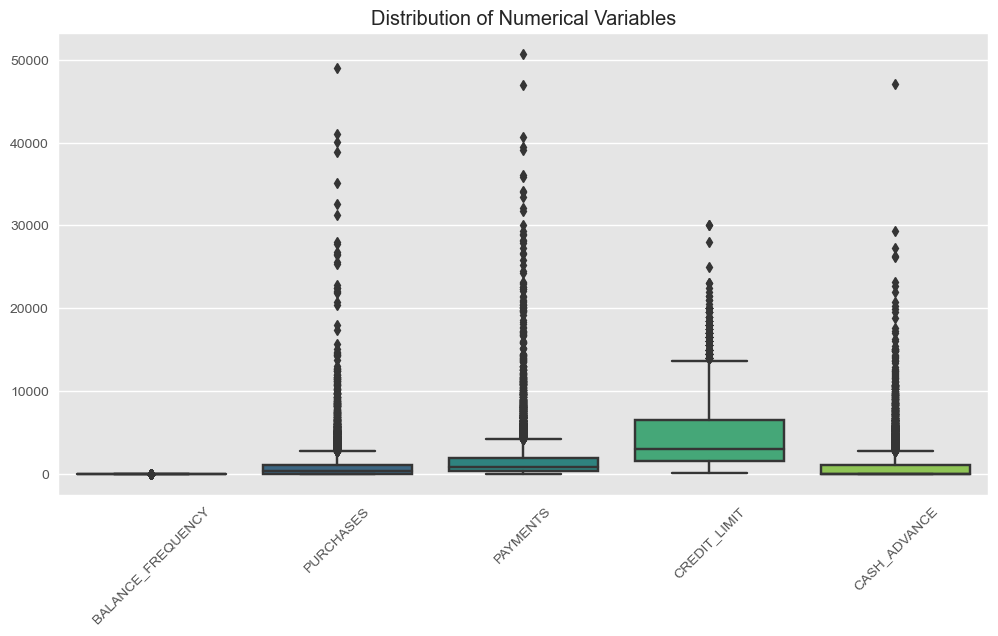

In [38]:
# handling outliers
num_vars=df.select_dtypes(include=['int64','float64'])
#calculate the number of outliers for each numerical variable
outliers_count = ((num_vars < num_vars.quantile(0.25) - 1.5 * (num_vars.quantile(0.75) - num_vars.quantile(0.25))) |
                  (num_vars > num_vars.quantile(0.75) + 1.5 * (num_vars.quantile(0.75) - num_vars.quantile(0.25))))
outliers_count = outliers_count.sum()
# Display the number of outliers in a table
print(outliers_count)

# Create a boxplot to show the distribution of each numerical variable
plt.figure(figsize=(12, 6))
sns.boxplot(data=num_vars, palette='viridis')
plt.title('Distribution of Numerical Variables')
plt.xticks(rotation=45)

plt.show()

In [39]:
# Identify outliers using the IQR method
Q1 = num_vars.quantile(0.25)
Q3 = num_vars.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with NaN
num_vars_outliers_replaced = num_vars.mask((num_vars < lower_bound) | (num_vars > upper_bound))

In [40]:
# Replace NaN values with median
num_vars_outliers_replaced_median = num_vars_outliers_replaced.fillna(num_vars.median())

BALANCE_FREQUENCY    1246
PURCHASES             602
PAYMENTS              543
CREDIT_LIMIT           81
CASH_ADVANCE         1451
dtype: int64


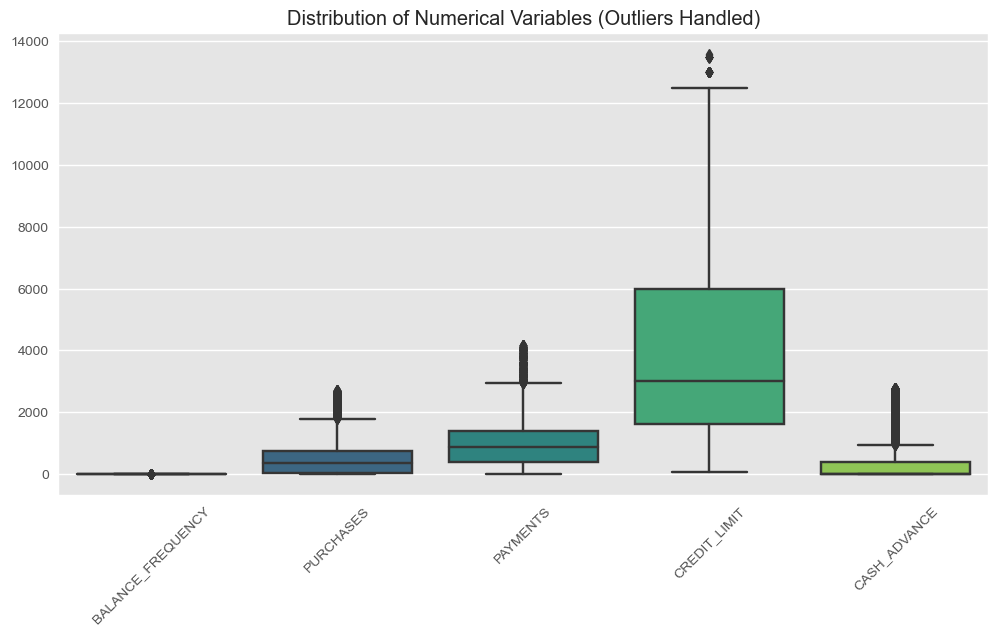

In [41]:
num_vars_outliers_replaced_median
#calculate the number of outliers for each numerical variable
outliers_count = ((num_vars_outliers_replaced_median < num_vars_outliers_replaced_median.quantile(0.25) - 1.5 * (num_vars_outliers_replaced_median.quantile(0.75) - num_vars_outliers_replaced_median.quantile(0.25))) |
                  (num_vars_outliers_replaced_median > num_vars_outliers_replaced_median.quantile(0.75) + 1.5 * (num_vars_outliers_replaced_median.quantile(0.75) - num_vars_outliers_replaced_median.quantile(0.25))))
outliers_count = outliers_count.sum()

# Display the number of outliers in a table
print(outliers_count)

# Create a boxplot to show the distribution of each numerical variable after handling outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=num_vars_outliers_replaced_median, palette='viridis')
plt.title('Distribution of Numerical Variables (Outliers Handled)')
plt.xticks(rotation=45)
plt.show()

In [42]:
num_vars_outliers_replaced_median.head()

,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,0.818182,95.40,201.802084,1000.0,0.000000
1,0.909091,0.00,4103.032597,7000.0,0.000000
2,1.000000,773.17,622.066742,7500.0,0.000000
3,1.000000,1499.00,0.000000,7500.0,205.788017
4,1.000000,16.00,678.334763,1200.0,0.000000


In [43]:
# Merge num_vars_outliers_replaced_median with the original dataset data
df_merged = df.copy()  # Create a copy of the original dataset

In [44]:
# Update the numerical columns in data_merged with values from num_vars_outliers_replaced_median
df_merged.update(num_vars_outliers_replaced_median)

The outliers in the numerical variables has been removed by replacing it with the median of the columns

In [45]:
df_merged.describe().astype('int')

,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
count,8950,8950,8950,8950,8950
mean,0,524,1047,4118,352
std,0,622,910,2991,657
min,0,0,0,50,0
25%,1,39,383,1600,0
50%,1,361,856,3000,0
75%,1,739,1402,6000,378
max,1,2711,4177,13600,2784


- The dataset appears to represent credit card usage behavior over a period, with information about balance frequency, purchases, payments, credit limits, and cash advances.
- Users in the dataset have varying patterns of behavior, with some making frequent purchases and payments, while others have lower activity levels.
- There are instances of high-value transactions, such as large purchases, payments, and cash advances, indicating diverse user behavior.

In [46]:
df_merged[["PURCHASES","CREDIT_LIMIT"]].describe().astype("int")

,PURCHASES,CREDIT_LIMIT
count,8950,8950
mean,524,4118
std,622,2991
min,0,50
25%,39,1600
50%,361,3000
75%,739,6000
max,2711,13600


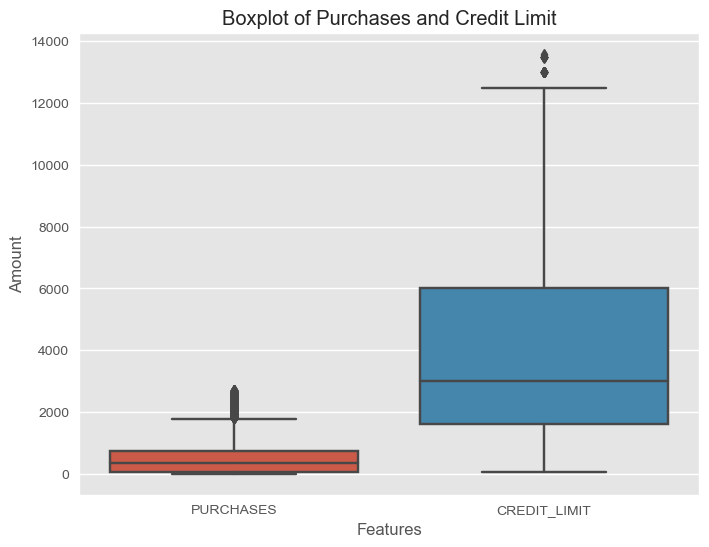

In [47]:
# Plot boxplot of 'PURCHASES' and 'CREDIT_LIMIT'
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_merged[['PURCHASES', 'CREDIT_LIMIT']])
plt.title('Boxplot of Purchases and Credit Limit')
plt.ylabel('Amount')
plt.xlabel('Features')
plt.show()

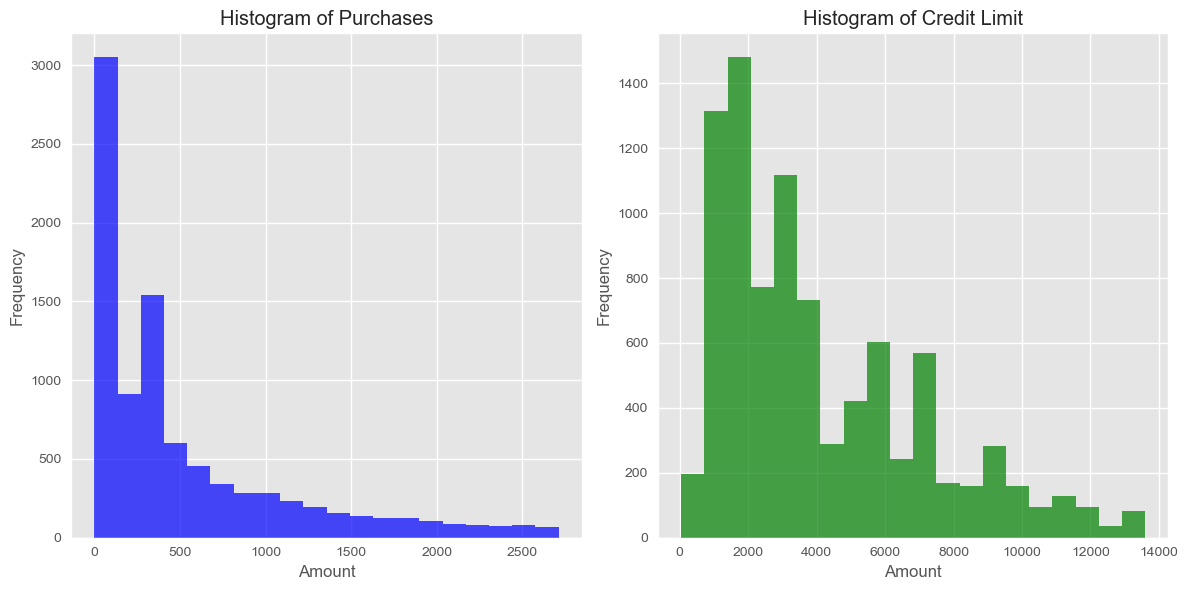

In [48]:
# Create separate subplots for 'PURCHASES' and 'CREDIT_LIMIT' histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot histogram for 'PURCHASES'
axes[0].hist(df_merged['PURCHASES'], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Histogram of Purchases')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')

# Plot histogram for 'CREDIT_LIMIT'
axes[1].hist(df_merged['CREDIT_LIMIT'], bins=20, color='green', alpha=0.7)
axes[1].set_title('Histogram of Credit Limit')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature Selection

In [49]:
# selecting features for clustering
selected_features = df_merged[['PURCHASES', 'CREDIT_LIMIT']]

# Check the first few rows of the new DataFrame with selected features
selected_features.head()

,PURCHASES,CREDIT_LIMIT
0,95.40,1000.0
1,0.00,7000.0
2,773.17,7500.0
3,1499.00,7500.0
4,16.00,1200.0


- Standardizing data features before clustering helps in achieving more meaningful and robust clusters by ensuring that all features are treated equally and preventing biases that may arise due to differences in feature scales.

In [50]:
# Standardize the features
from sklearn.preprocessing import StandardScaler

# Assuming selected_features is your feature matrix
# Initialize and define selected_features here

# Instantiate the StandardScaler
scaler = StandardScaler()

# Scale the feature matrix
selected_features_scaled = scaler.fit_transform(selected_features)

# Display the scaled features
selected_features_scaled

array([[-0.68937009, -1.04247954],
       [-0.84260689,  0.96315267],
       [ 0.39930184,  1.13028869],
       ...,
       [-0.61066356, -1.04247954],
       [-0.84260689, -1.20961556],
       [ 0.91343218, -0.97562514]])

# Hierarchical Clustering

In [51]:
from sklearn.cluster import AgglomerativeClustering

# drop the 'Cust_ID' column
df_merged.drop(columns=['CUST_ID'],inplace=True)

# selected features 'PURCHASES' and 'CREDIT_LIMIT'
selected_features = df_merged[['PURCHASES', 'CREDIT_LIMIT']]

# Performing Hierarchical Clustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster_labels = cluster.fit_predict(selected_features)

# Adding the cluster labels back to the DataFrame
df_merged['CLUSTER'] = cluster_labels

# Display the DataFrame with cluster labels
df_merged.head()

,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE,CLUSTER
0,0.818182,95.40,201.802084,1000.0,0.000000,1
1,0.909091,0.00,4103.032597,7000.0,0.000000,0
2,1.000000,773.17,622.066742,7500.0,0.000000,0
3,1.000000,1499.00,0.000000,7500.0,205.788017,0
4,1.000000,16.00,678.334763,1200.0,0.000000,1


# Hierarchical Clustering

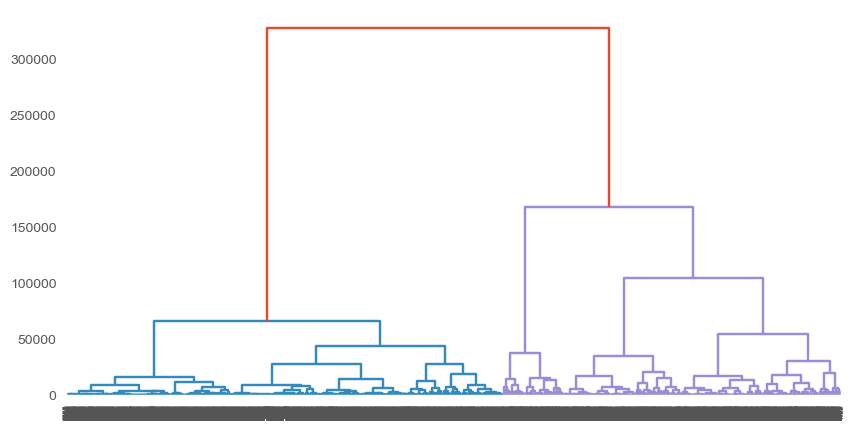

In [52]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical clustering
Z = linkage(df_merged[['PURCHASES', 'CREDIT_LIMIT']], 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z)
plt.show()



# K-means Clsutering

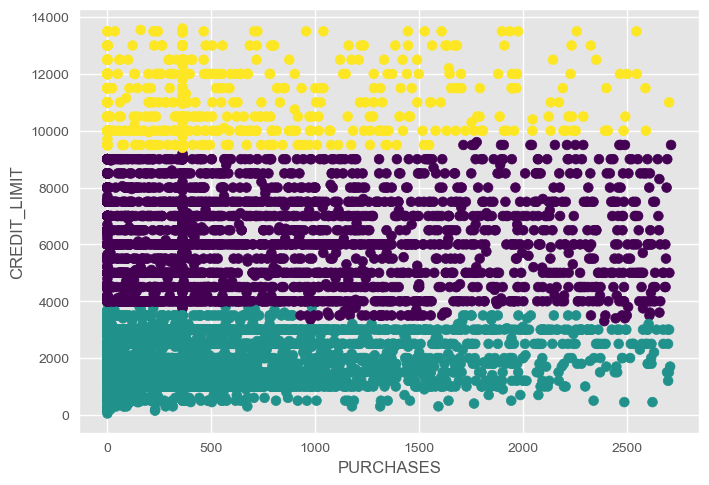

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-means clustering
kmeans = KMeans(n_clusters=3)


# Plot the clusters
plt.scatter(df_merged['PURCHASES'], df_merged['CREDIT_LIMIT'], c=df_merged['CLUSTER'], cmap='viridis')
plt.xlabel('PURCHASES')
plt.ylabel('CREDIT_LIMIT')
plt.show()


# Partitional Cluster (K-MEANS)

      BALANCE_FREQUENCY  PURCHASES     PAYMENTS  CREDIT_LIMIT  CASH_ADVANCE  \
0              0.818182      95.40   201.802084        1000.0      0.000000   
1              0.909091       0.00  4103.032597        7000.0      0.000000   
2              1.000000     773.17   622.066742        7500.0      0.000000   
3              1.000000    1499.00     0.000000        7500.0    205.788017   
4              1.000000      16.00   678.334763        1200.0      0.000000   
...                 ...        ...          ...           ...           ...   
8945           1.000000     291.12   325.594462        1000.0      0.000000   
8946           1.000000     300.00   275.861322        1000.0      0.000000   
8947           0.833333     144.40    81.270775        1000.0      0.000000   
8948           0.833333       0.00    52.549959         500.0     36.558778   
8949           1.000000    1093.25    63.165404        1200.0    127.040008   

      CLUSTER  
0           1  
1           0  
2  

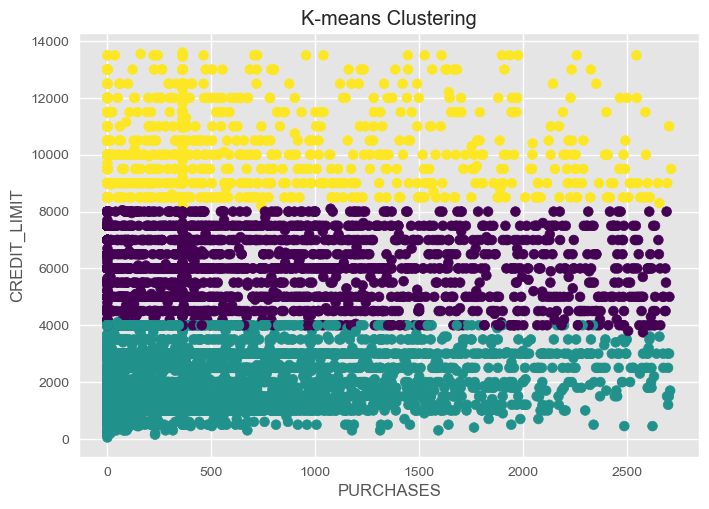

In [54]:
from sklearn.cluster import KMeans

selected_features = pd.DataFrame(df_merged)

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
cluster_labels = kmeans.fit_predict(selected_features)

# Add cluster labels to the DataFrame
selected_features['CLUSTER'] = cluster_labels

# Display the DataFrame with cluster labels
print(selected_features)

# Plot the clusters
plt.scatter(selected_features['PURCHASES'], selected_features['CREDIT_LIMIT'], c=cluster_labels, cmap='viridis')
plt.xlabel('PURCHASES')
plt.ylabel('CREDIT_LIMIT')
plt.title('K-means Clustering')
plt.show()

## Summary Report
- Cluster 1 seems to have users with lower credit limits of (4,000) and max purchase concentration of (1,700)varying purchase amounts.
- Cluster 2 appears to include users with higher credit limits(8,000) and max purchase concentration (1,500) potentially higher purchase amounts.
- Cluster 3 appears to include users with a high credit limits (11,000) and max purchase concentration (1,000)

In [55]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


# Finding the best K-value using Elbow Method

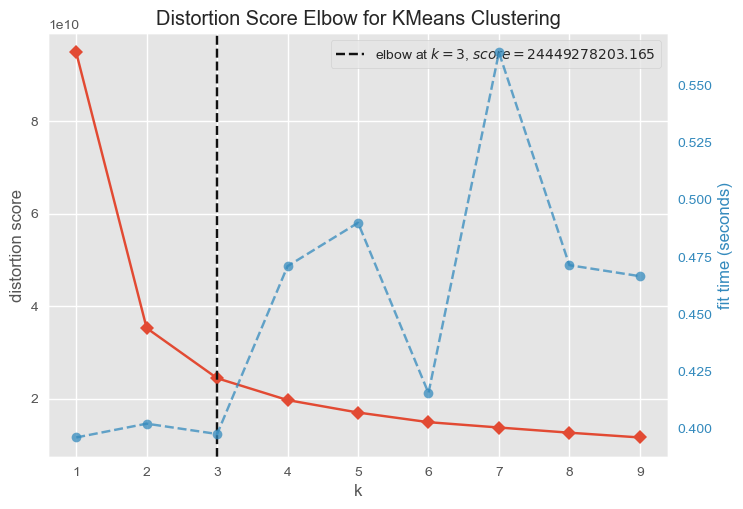

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
from yellowbrick.cluster import KElbowVisualizer

# Using the 'selected_features' which is the DataFrame with the selected features
# Instantiate the KMeans model
model = KMeans()

# Use the elbow method to find the optimal value of K
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(selected_features)
visualizer.show()

The best k-value is 3